# Vehicle Detection
This notebook allows a trained model to be loaded into a detection class which then operates over an image (static or video) to identify vehicles

In [46]:
# imports
import feature_extraction as fe
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage.measurements import label
%matplotlib inline

In [73]:
class vehicle_detector:
    
    def __init__(self, params=None, model=None, scaler = None, scale=1.5, crop=(400,656)):
        self.extraction_params = params
        self.model = model
        self.scaler = scaler
        self.scale = 1.5
        self.crop = crop
        self.color_list = color_list = {
            'RGB': cv2.COLOR_BGR2RGB,
            'HSV': cv2.COLOR_BGR2HSV,
            'LUV': cv2.COLOR_BGR2LUV,
            'HLS': cv2.COLOR_BGR2HLS,
            'YUV': cv2.COLOR_BGR2YUV,
            'YCrCb': cv2.COLOR_BGR2YCrCb
        }
        self.detected_windows = []
        
    def initialise_image(self, img):
        """
            function to normalise, color convert and crop the image
            Args:
                img: the image to initialise
            Returns:
                search_img: the processed image
        """
        img = img.astype(np.float32)/255
        
        # crop
        search_img = img[self.crop[0]:self.crop[1],:,:]
        
        # color_convert
        conversion = self.color_list[self.extraction_params['color_space']]
        search_img = cv2.cvtColor(search_img, conversion)

        # scale image
        if self.scale != 1:
            imshape = search_img.shape
            search_img = cv2.resize(search_img, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))

        return search_img
        
    def get_all_hog_features(self, search_img):
        """
            function to generate all hog features for the image
            Args:
                search_img: the image to generate
            Returns:
                hog1, hog2, hog3: the features for each channel
        """
        
        # Compute individual channel HOG features for the entire image
        hog1 = fe.get_hog_features(search_img[:,:,0], self.extraction_params['orient'], 
                                self.extraction_params['pix_per_cell'],
                                self.extraction_params['cell_per_block'], feature_vec=False)
        
        hog2 = fe.get_hog_features(search_img[:,:,1], self.extraction_params['orient'], 
                                self.extraction_params['pix_per_cell'],
                                self.extraction_params['cell_per_block'], feature_vec=False)
        
        hog3 = fe.get_hog_features(search_img[:,:,2], self.extraction_params['orient'], 
                                self.extraction_params['pix_per_cell'],
                                self.extraction_params['cell_per_block'], feature_vec=False)
        
        return hog1, hog2, hog3
    
    def run_windows(self, search_img, draw_img, hog1, hog2, hog3):
        """
            function to run the sliding window search and return an image with detected vehicles
            Args:
                search_img: the image to search
                draw_img: the image to draw on
                hog1, hog2, hog3: the hog features for the entire image
            Returns
                draw_img: the image with the boxes drawn on
        """
        
        # Define blocks and steps as above
        nxblocks = (search_img.shape[1] // self.extraction_params['pix_per_cell']) - self.extraction_params['cell_per_block'] + 1
        nyblocks = (search_img.shape[0] // self.extraction_params['pix_per_cell']) - self.extraction_params['cell_per_block'] + 1 
        nfeat_per_block = self.extraction_params['orient']*self.extraction_params['cell_per_block']**2
    
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.extraction_params['pix_per_cell']) - self.extraction_params['cell_per_block'] + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
            
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*self.extraction_params['pix_per_cell']
                ytop = ypos*self.extraction_params['pix_per_cell']

                # Extract the image patch
                subimg = cv2.resize(search_img[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                # Get color features
                spatial_features = fe.bin_spatial(subimg, size=self.extraction_params['spatial_size'])
                hist_features = fe.color_hist(subimg, nbins=self.extraction_params['hist_bins'])
            
                # Scale features and make a prediction
                test_features = self.scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = self.model.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*self.scale)
                    ytop_draw = np.int(ytop*self.scale)
                    win_draw = np.int(window*self.scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+self.crop[0]),
                                  (xbox_left+win_draw,ytop_draw+win_draw+self.crop[0]),(0,0,255),6) 
                    self.detected_windows.append([(xbox_left, ytop_draw+self.crop[0]), 
                                                  (xbox_left+win_draw,ytop_draw+win_draw+self.crop[0])])
                    
        return draw_img

    def add_heat_and_threshold(self, heatmap, threshold):
        """
            function creating a heatmap
            
        """
        # Iterate through list of bboxes
        for box in self.detected_windows:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        heatmap[heatmap <= threshold] = 0
        
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        """
            function drawing bounding boxes onto the image
            Args:
                img: base image to draw onto
                labels: the boxes to draw
            Returns
                draw_img: the image with the boxes
        """
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
        # Return the image
        return img
    
    def process_image(self, img, mode='single'):
        """
            function to apply detection technique to image
            Args:
                img: the image to operate on
                mode: 
                    'single' will draw various outputs and return an image with detected vehicles
                    'video' will just output the detected vehicle images
            Returns:
                draw_img: the image with bounding boxes showing the images detected
        """
        conversion = self.color_list[self.extraction_params['color_space']]
        draw_img = cv2.cvtColor(np.copy(img), conversion)
        
        # get the image to search over
        search_img = self.initialise_image(img)
    
        # get hog for all image
        hog1, hog2, hog3 = self.get_all_hog_features(search_img)
        
        # run the sliding window and prediction...
        draw_img = self.run_windows(search_img, draw_img, hog1, hog2, hog3)
        
        # Add heat to each box in box list
        heat = self.add_heat_and_threshold(np.zeros_like(img[:,:,0]).astype(np.float), 2)
    
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        # color_convert
        img = img.astype(np.float32)/255
        conversion = self.color_list[self.extraction_params['color_space']]
        draw_img = cv2.cvtColor(img, conversion)
        draw_img = self.draw_labeled_bboxes(draw_img, labels)
        
        return draw_img, heatmap    

In [74]:
filename = 'model.pkl'
pkl_file = open(filename, 'rb')

data1 = pickle.load(pkl_file)
model = data1['model']
scaler = data1['scaler']
pkl_file.close()

filename = 'extraction_features.pkl'
features_file = open(filename, 'rb')

features = pickle.load(features_file)
features_file.close()

detector = vehicle_detector(features, model, scaler)

In [75]:
img = cv2.imread('test_images/test1.jpg')
draw_img, heatmap = detector.process_image(img)

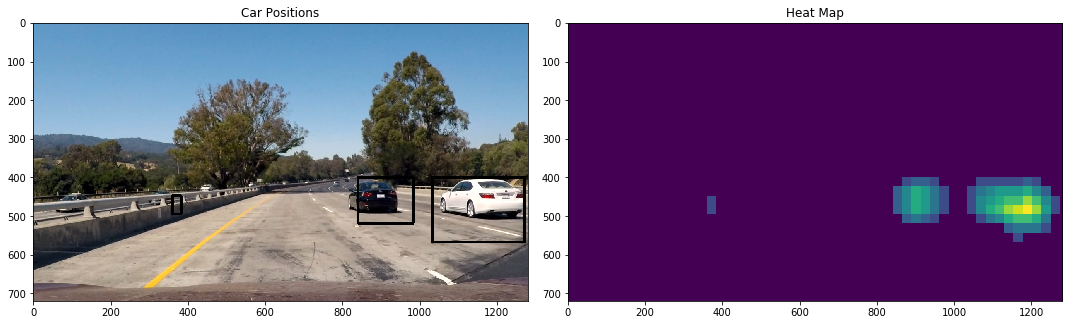

In [76]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap)
plt.title('Heat Map')
fig.tight_layout()

In [ ]:
# t do: think about detected windows over frame, 
# sort out various draw images and pixel ranges..., 
# do test images end to end, convert to video stream
# think about which odel and color space also